<a href="https://colab.research.google.com/github/regismunez/CienciaDatosEjemplos/blob/main/Implementaci%C3%B3n_de_RNN%2C_LSTM_y_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 # PRÁCTICA 4: REDES NEURONALES RECURRENTES
Implementación de RNN, LSTM y GRU

 **Estudiante:** [Regis Munez]
 **Fecha:** [2025]



## Configuración inicial e importación de librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


# MODELO 1: RNN SIMPLE - PREDICCIÓN DE SERIES TEMPORALES

## Fase 1: Exploración del Dataset - Temperatura Global

Primeras 10 filas del dataset:
   time  temperature
0     0    13.259186
1     1    15.814477
2     2    17.048093
3     3    18.506105
4     4    17.277747
5     5    16.325921
6     6    14.681392
7     7    16.409027
8     8    19.990627
9     9    13.505721

Estadísticas descriptivas:
              time  temperature
count  1000.000000  1000.000000
mean    499.500000    30.585503
std     288.819436    10.498669
min       0.000000     9.330542
25%     249.750000    22.739123
50%     499.500000    29.803459
75%     749.250000    38.127397
max     999.000000    52.932156


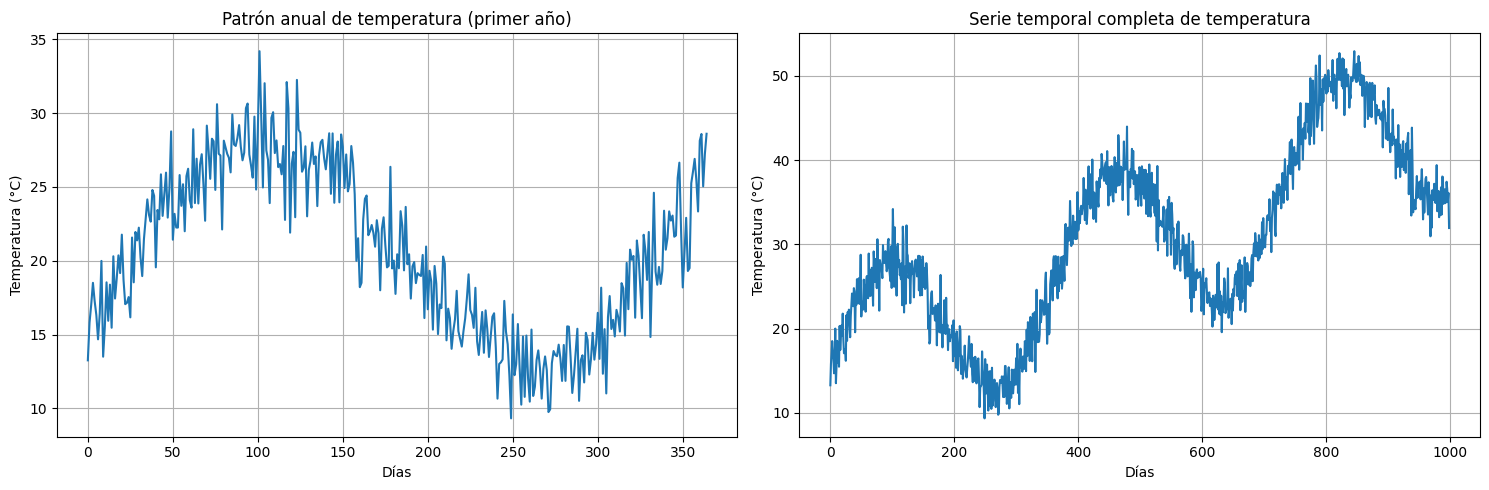

In [ ]:
# Cargar dataset de temperatura (simulado)
def generate_temperature_data(n=1000):
    time = np.arange(0, n)
    # Patrón estacional + tendencia + ruido
    seasonal = 10 * np.sin(2 * np.pi * time / 365)
    trend = 0.03 * time
    noise = np.random.normal(0, 2, n)
    temperature = 15 + seasonal + trend + noise
    return time, temperature

time, temperature = generate_temperature_data(1000)

# Crear DataFrame
temp_df = pd.DataFrame({
    'time': time,
    'temperature': temperature
})

print("Primeras 10 filas del dataset:")
print(temp_df.head(10))

print(f"\nEstadísticas descriptivas:")
print(temp_df.describe())

# %%
# Visualización de la serie temporal
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(temp_df['time'][:365], temp_df['temperature'][:365])
plt.title('Patrón anual de temperatura (primer año)')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(temp_df['time'], temp_df['temperature'])
plt.title('Serie temporal completa de temperatura')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Fase 2: Preprocesamiento - Series Temporales

In [ ]:
# Preparar datos para RNN
def create_sequences(data, sequence_length=30):
    sequences = []
    targets = []

    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Normalizar datos
scaler = MinMaxScaler()
temperature_scaled = scaler.fit_transform(temp_df[['temperature']])

# Crear secuencias
sequence_length = 30
X, y = create_sequences(temperature_scaled.flatten(), sequence_length)

print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionar para RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Forma final X_train: {X_train.shape}")
print(f"Forma final X_test: {X_test.shape}")

Forma de X: (970, 30)
Forma de y: (970,)
Forma final X_train: (776, 30, 1)
Forma final X_test: (194, 30, 1)


## Fase 3: Definición del Modelo RNN Simple

In [ ]:
# Modelo RNN Simple
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(30, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

rnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 30)             │         2,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

## Fase 4: Entrenamiento y Evaluación

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.1439 - mae: 0.2991 - val_loss: 0.0059 - val_mae: 0.0601
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0695 - mae: 0.2052 - val_loss: 0.0054 - val_mae: 0.0592
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0457 - mae: 0.1652 - val_loss: 0.0110 - val_mae: 0.0877
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0331 - mae: 0.1460 - val_loss: 0.0039 - val_mae: 0.0499
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0250 - mae: 0.1222 - val_loss: 0.0031 - val_mae: 0.0459
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0225 - mae: 0.1190 - val_loss: 0.0038 - val_mae: 0.0515
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0237 - mae: 0.1215 - val_loss: 0.0032 - val_mae: 0.0453
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0199 - mae: 0.1135 - val_loss: 0.0039 - val_mae: 0.0495
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.019

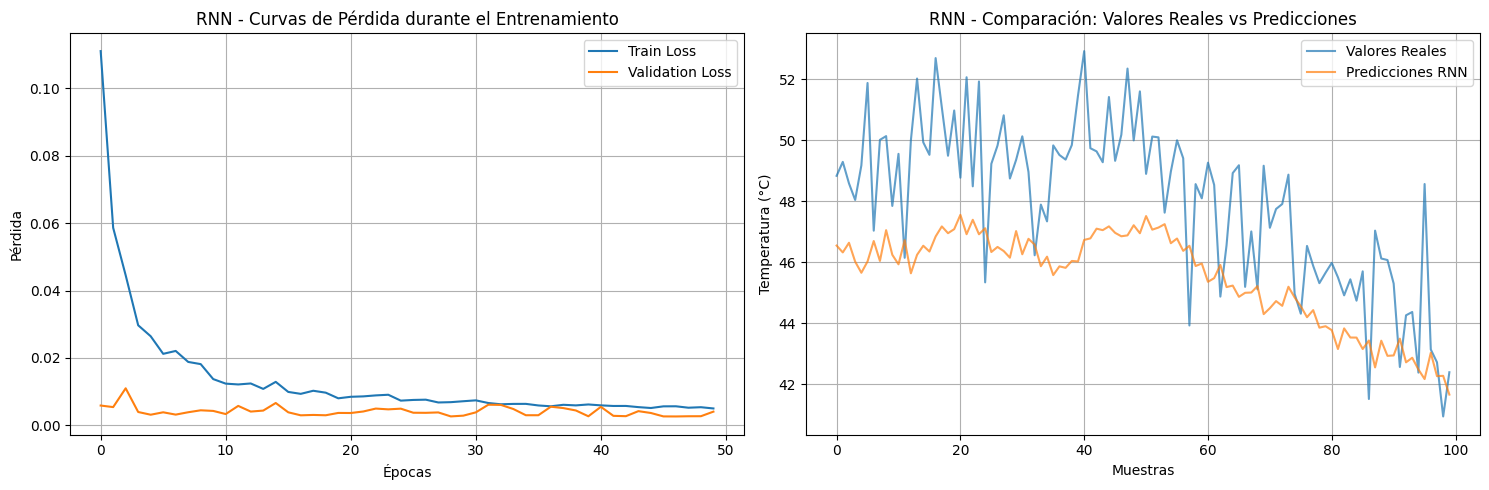

In [ ]:
# Entrenamiento
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# %%
# Evaluación
train_loss, train_mae = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f"RNN - Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"RNN - Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predicciones
y_pred_rnn = rnn_model.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred_rnn)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular RMSE
rmse_rnn = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"RNN - RMSE: {rmse_rnn:.2f}°C")

# %%
# Visualización de resultados
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN - Curvas de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(y_test_original[:100], label='Valores Reales', alpha=0.7)
plt.plot(y_pred_original[:100], label='Predicciones RNN', alpha=0.7)
plt.title('RNN - Comparación: Valores Reales vs Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# MODELO 2: LSTM - ANÁLISIS DE SENTIMIENTOS

## Fase 1: Exploración del Dataset - Texto

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Ejemplo de review (índices):
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]

Sentimiento: 1 (0: Negativo, 1: Positivo)

Distribución de clases:
Train - Positivos: 12500, Negativos: 12500
Test - Positivos: 12500, Negativos: 12500


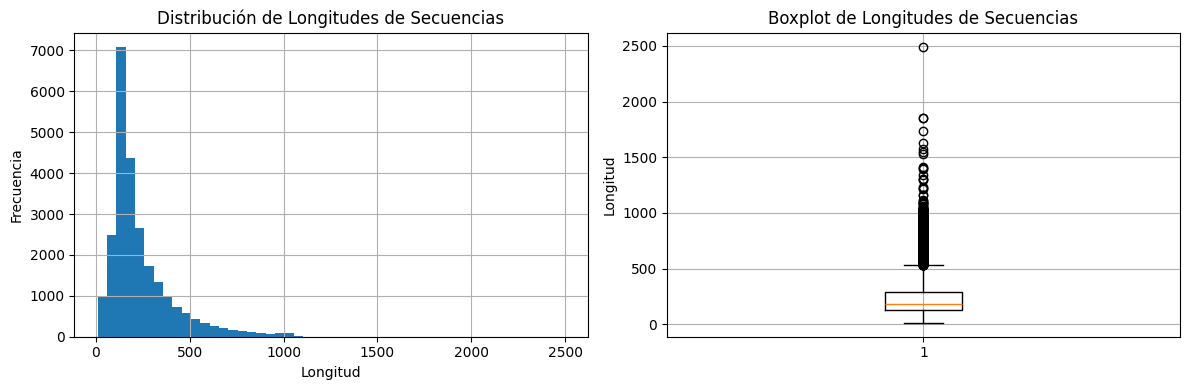

Longitud máxima: 2494
Longitud mínima: 11
Longitud promedio: 238.71


In [ ]:
# Dataset de análisis de sentimientos (IMDB simplificado)
from tensorflow.keras.datasets import imdb

# Cargar datos
vocab_size = 10000
max_length = 200

(X_train_lstm, y_train_lstm), (X_test_lstm, y_test_lstm) = imdb.load_data(num_words=vocab_size)

print("Ejemplo de review (índices):")
print(X_train_lstm[0][:20])

print(f"\nSentimiento: {y_train_lstm[0]} (0: Negativo, 1: Positivo)")

print(f"\nDistribución de clases:")
print(f"Train - Positivos: {np.sum(y_train_lstm)}, Negativos: {len(y_train_lstm) - np.sum(y_train_lstm)}")
print(f"Test - Positivos: {np.sum(y_test_lstm)}, Negativos: {len(y_test_lstm) - np.sum(y_test_lstm)}")

# %%
# Analizar longitud de secuencias
sequence_lengths = [len(seq) for seq in X_train_lstm]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sequence_lengths, bins=50)
plt.title('Distribución de Longitudes de Secuencias')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(sequence_lengths)
plt.title('Boxplot de Longitudes de Secuencias')
plt.ylabel('Longitud')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Longitud máxima: {max(sequence_lengths)}")
print(f"Longitud mínima: {min(sequence_lengths)}")
print(f"Longitud promedio: {np.mean(sequence_lengths):.2f}")


## Fase 2: Preprocesamiento - Texto

In [ ]:
# Padding de secuencias
X_train_padded = pad_sequences(X_train_lstm, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_lstm, maxlen=max_length, padding='post', truncating='post')

print(f"Forma después del padding:")
print(f"X_train_padded: {X_train_padded.shape}")
print(f"X_test_padded: {X_test_padded.shape}")

# Diccionario de palabras
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review if i >= 3])

print("\nEjemplo de review decodificado:")
print(decode_review(X_train_lstm[0])[:200])

Forma después del padding:
X_train_padded: (25000, 200)
X_test_padded: (25000, 200)
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Ejemplo de review decodificado:
this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert is an amazing actor and now the same b


 ## Fase 3: Definición del Modelo LSTM

In [ ]:
# Modelo LSTM para análisis de sentimientos
lstm_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Fase 4: Entrenamiento y Evaluación


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 675ms/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.5062 - val_loss: 0.6913
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 99s 629ms/step - accuracy: 0.5058 - loss: 0.6938 - val_accuracy: 0.5062 - val_loss: 0.6913
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 147s 661ms/step - accuracy: 0.5101 - loss: 0.6913 - val_accuracy: 0.4996 - val_loss: 0.6912
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 637ms/step - accuracy: 0.5066 - loss: 0.6920 - val_accuracy: 0.4994 - val_loss: 0.6911
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 99s 632ms/step - accuracy: 0.5079 - loss: 0.6911 - val_accuracy: 0.5408 - val_loss: 0.6903
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 635ms/step - accuracy: 0.5252 - loss: 0.6869 - val_accuracy: 0.5934 - val_loss: 0.6637
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 628ms/step - accuracy: 0.5670 - loss: 0.6670 - val_accuracy: 0.4968 - val_loss: 0.6926
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 98s 627ms/step - accuracy: 0.5461 - lo

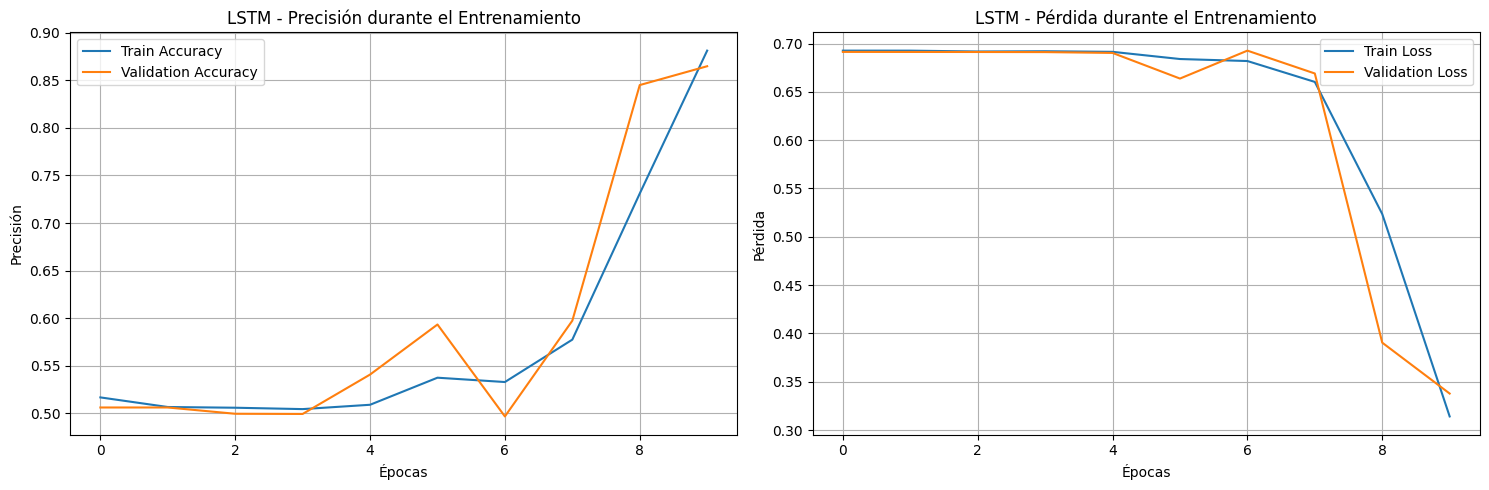

In [ ]:
# Entrenamiento
history_lstm = lstm_model.fit(
    X_train_padded, y_train_lstm,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# %%
# Evaluación
train_loss_lstm, train_acc_lstm = lstm_model.evaluate(X_train_padded, y_train_lstm, verbose=0)
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(X_test_padded, y_test_lstm, verbose=0)

print(f"LSTM - Train Accuracy: {train_acc_lstm:.4f}")
print(f"LSTM - Test Accuracy: {test_acc_lstm:.4f}")

# Predicciones
y_pred_lstm = (lstm_model.predict(X_test_padded) > 0.5).astype("int32")
f1_lstm = f1_score(y_test_lstm, y_pred_lstm)

print(f"LSTM - F1-Score: {f1_lstm:.4f}")

# %%
# Visualización de resultados
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM - Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM - Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# MODELO 3: GRU - PREDICCIÓN FINANCIERA

## Fase 1: Exploración del Dataset - Datos Financieros

Primeras 10 filas del dataset financiero:
   day       price        volume
0    0  101.099428  89264.168397
1    1  100.921116  55527.500577
2    2  102.339217  23379.862874
3    3  105.610051  11534.100901
4    4  105.221798  44277.118652
5    5  104.835006  32646.253651
6    6  108.307240  53916.574811
7    7  110.092475  41571.570105
8    8  109.172719  62915.807034
9    9  110.474244  12897.190661

Estadísticas descriptivas:
             price         volume
count  1000.000000    1000.000000
mean    179.420202   38565.900044
std      84.951633   47450.306469
min      82.925107    1163.992710
25%     123.892745   12013.168800
50%     168.082693   23460.609647
75%     189.046170   45655.736128
max     457.196661  536653.314326


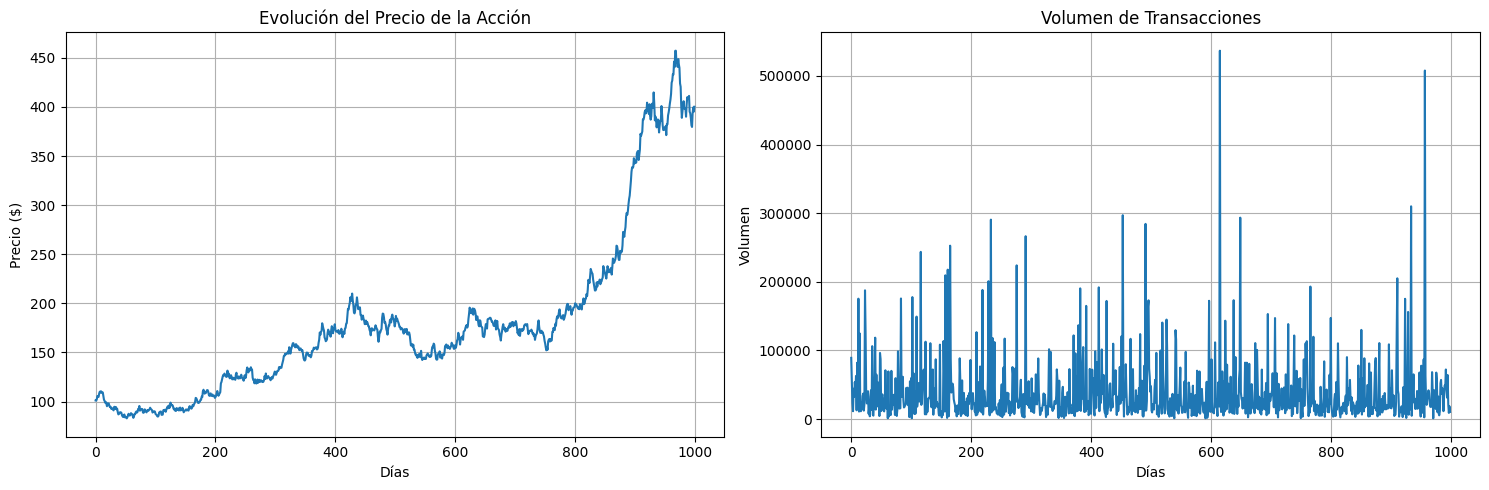

In [10]:
# Generar datos financieros simulados (precios de acciones)
def generate_stock_data(n=1000):
    np.random.seed(42)
    returns = np.random.normal(0.001, 0.02, n)
    price = 100 * np.exp(np.cumsum(returns))

    # Añadir volumen
    volume = np.random.lognormal(10, 1, n)

    return price, volume

price, volume = generate_stock_data(1000)

# Crear DataFrame
stock_df = pd.DataFrame({
    'day': np.arange(1000),
    'price': price,
    'volume': volume
})

print("Primeras 10 filas del dataset financiero:")
print(stock_df.head(10))

print(f"\nEstadísticas descriptivas:")
print(stock_df[['price', 'volume']].describe())

# %%
# Visualización de datos financieros
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(stock_df['day'], stock_df['price'])
plt.title('Evolución del Precio de la Acción')
plt.xlabel('Días')
plt.ylabel('Precio ($)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(stock_df['day'], stock_df['volume'])
plt.title('Volumen de Transacciones')
plt.xlabel('Días')
plt.ylabel('Volumen')
plt.grid(True)

plt.tight_layout()
plt.show()

## Fase 2: Preprocesamiento - Datos Financieros

In [11]:
# Preparar características múltiples
features = stock_df[['price', 'volume']].values

# Normalizar
scaler_stock = MinMaxScaler()
features_scaled = scaler_stock.fit_transform(features)

# Crear secuencias para predicción de precio
def create_multivariate_sequences(data, target_col=0, sequence_length=20):
    sequences = []
    targets = []

    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length, target_col]  # Predecir precio
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

X_stock, y_stock = create_multivariate_sequences(features_scaled, sequence_length=20)

print(f"Forma de X_stock: {X_stock.shape}")
print(f"Forma de y_stock: {y_stock.shape}")

# Dividir datos
X_train_stock, X_test_stock, y_train_stock, y_test_stock = train_test_split(
    X_stock, y_stock, test_size=0.2, shuffle=False
)

print(f"Train: {X_train_stock.shape}, Test: {X_test_stock.shape}")

Forma de X_stock: (980, 20, 2)
Forma de y_stock: (980,)
Train: (784, 20, 2), Test: (196, 20, 2)


## Fase 3: Definición del Modelo GRU

In [12]:
# Modelo GRU para predicción financiera
gru_model = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=(20, 2)),
    Dropout(0.3),
    GRU(32, activation='tanh'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)
])

gru_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

gru_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 64)         │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,009 (89.88 KB)

 Trainable params: 23,009 (89.88 KB)

 Non-trainable params: 0 (0.00 B)

 ## Fase 4: Entrenamiento y Evaluación

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0192 - mae: 0.1086 - val_loss: 0.0059 - val_mae: 0.0745
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0031 - mae: 0.0430 - val_loss: 4.0538e-04 - val_mae: 0.0152
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0011 - mae: 0.0237 - val_loss: 3.8294e-04 - val_mae: 0.0154
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.5846e-04 - mae: 0.0229 - val_loss: 3.0940e-04 - val_mae: 0.0141
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.7847e-04 - mae: 0.0211 - val_loss: 2.2596e-04 - val_mae: 0.0120
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.1139e-04 - mae: 0.0183 - val_loss: 2.1089e-04 - val_mae: 0.0115
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.8315e-04 - mae: 0.0200 - val_loss: 3.4328e-04 - val_mae: 0.0153
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.3630e-04 - mae: 0.0188 - val_loss: 2.2281e-04 - val_mae: 0.0118
Epoch 9/50
20/20

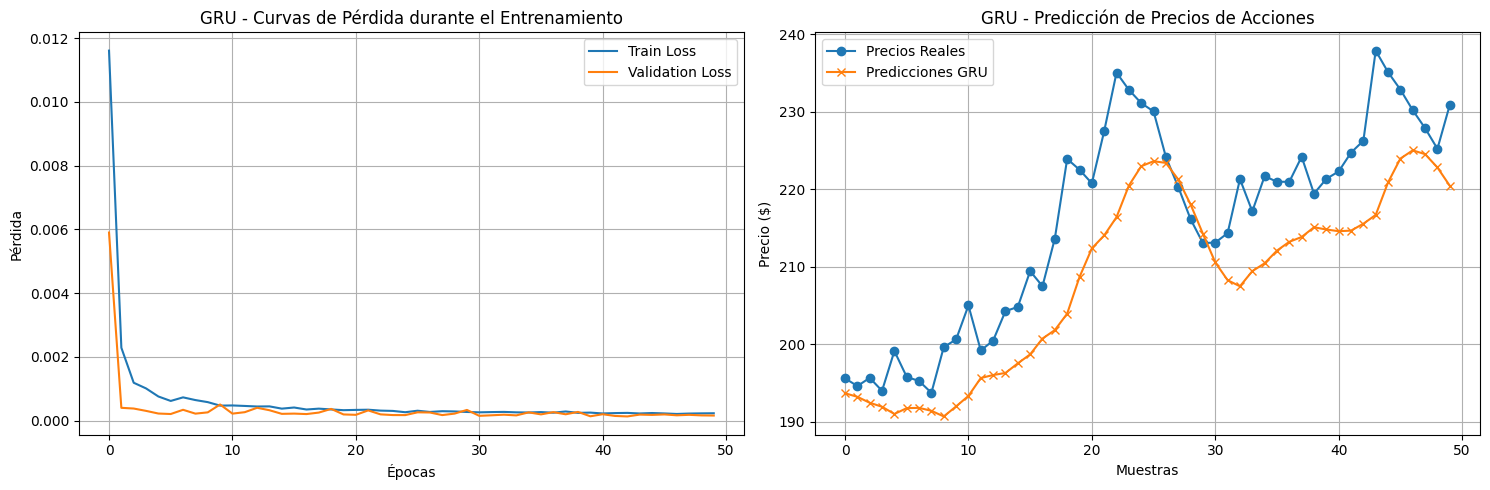

In [13]:
# Entrenamiento
history_gru = gru_model.fit(
    X_train_stock, y_train_stock,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# %%
# Evaluación
train_loss_gru, train_mae_gru = gru_model.evaluate(X_train_stock, y_train_stock, verbose=0)
test_loss_gru, test_mae_gru = gru_model.evaluate(X_test_stock, y_test_stock, verbose=0)

print(f"GRU - Train Loss: {train_loss_gru:.4f}, Train MAE: {train_mae_gru:.4f}")
print(f"GRU - Test Loss: {test_loss_gru:.4f}, Test MAE: {test_mae_gru:.4f}")

# Predicciones
y_pred_gru = gru_model.predict(X_test_stock)

# Recuperar escala original para el precio
y_test_original_stock = y_test_stock * (scaler_stock.data_max_[0] - scaler_stock.data_min_[0]) + scaler_stock.data_min_[0]
y_pred_original_stock = y_pred_gru.flatten() * (scaler_stock.data_max_[0] - scaler_stock.data_min_[0]) + scaler_stock.data_min_[0]

rmse_gru = np.sqrt(mean_squared_error(y_test_original_stock, y_pred_original_stock))
print(f"GRU - RMSE: ${rmse_gru:.2f}")

# %%
# Visualización de resultados
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU - Curvas de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(y_test_original_stock[:50], label='Precios Reales', marker='o')
plt.plot(y_pred_original_stock[:50], label='Predicciones GRU', marker='x')
plt.title('GRU - Predicción de Precios de Acciones')
plt.xlabel('Muestras')
plt.ylabel('Precio ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Fase 5: Análisis Comparativo de Resultados


RESUMEN COMPARATIVO DE MODELOS
    Modelo               Problema Métrica Principal     Otra Métrica
RNN Simple Predicción Temperatura      RMSE: 2.74°C      MAE: 0.0526
      LSTM  Análisis Sentimientos  F1-Score: 0.8381 Accuracy: 0.8462
       GRU  Predicción Financiera      RMSE: $24.20      MAE: 0.0558


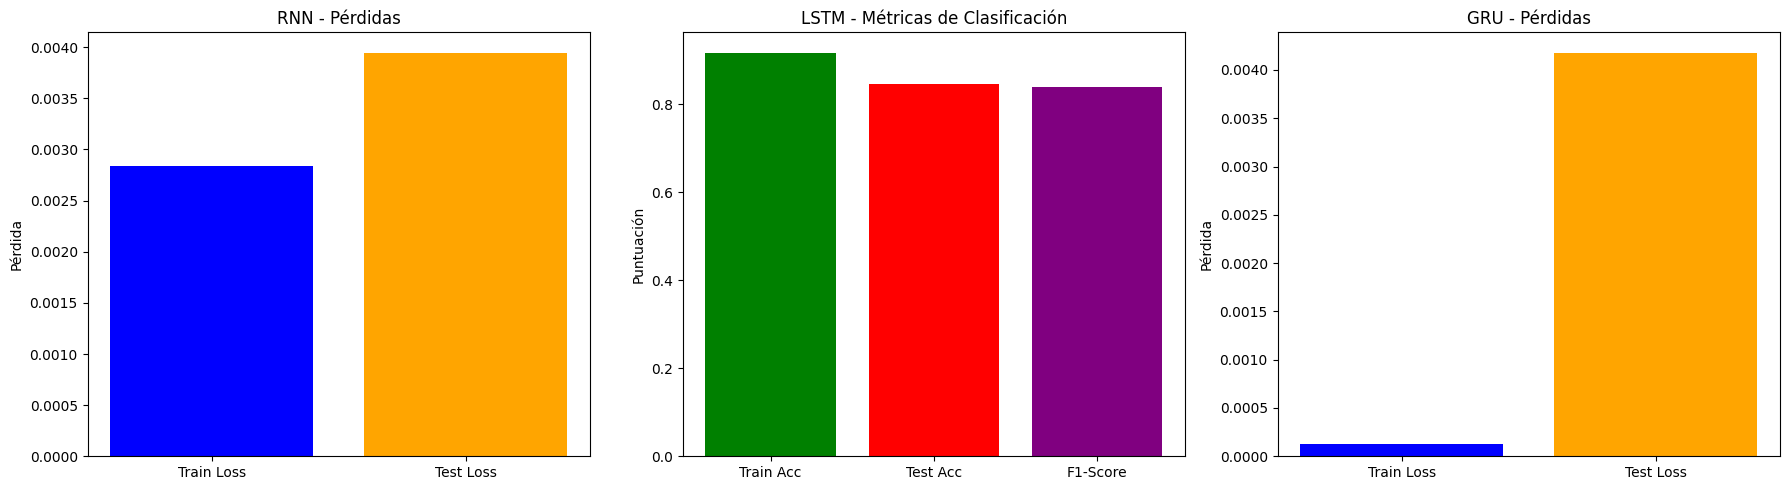

In [14]:
# Resumen comparativo
results_summary = pd.DataFrame({
    'Modelo': ['RNN Simple', 'LSTM', 'GRU'],
    'Problema': ['Predicción Temperatura', 'Análisis Sentimientos', 'Predicción Financiera'],
    'Métrica Principal': [f'RMSE: {rmse_rnn:.2f}°C', f'F1-Score: {f1_lstm:.4f}', f'RMSE: ${rmse_gru:.2f}'],
    'Otra Métrica': [f'MAE: {test_mae:.4f}', f'Accuracy: {test_acc_lstm:.4f}', f'MAE: {test_mae_gru:.4f}']
})

print("RESUMEN COMPARATIVO DE MODELOS")
print("=" * 60)
print(results_summary.to_string(index=False))

# %%
# Visualización comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RNN
axes[0].bar(['Train Loss', 'Test Loss'], [train_loss, test_loss], color=['blue', 'orange'])
axes[0].set_title('RNN - Pérdidas')
axes[0].set_ylabel('Pérdida')

# LSTM
axes[1].bar(['Train Acc', 'Test Acc', 'F1-Score'],
           [train_acc_lstm, test_acc_lstm, f1_lstm],
           color=['green', 'red', 'purple'])
axes[1].set_title('LSTM - Métricas de Clasificación')
axes[1].set_ylabel('Puntuación')

# GRU
axes[2].bar(['Train Loss', 'Test Loss'], [train_loss_gru, test_loss_gru], color=['blue', 'orange'])
axes[2].set_title('GRU - Pérdidas')
axes[2].set_ylabel('Pérdida')

plt.tight_layout()
plt.show()

1. RNN SIMPLE:
   - Aplicación: Predicción de series temporales (temperatura)
   - Rendimiento: Bueno para patrones estacionales simples
   - Ventajas: Computacionalmente eficiente, rápido entrenamiento
   - Limitaciones: Problema de desvanecimiento de gradientes en secuencias largas

2. LSTM:
   - Aplicación: Análisis de sentimientos en texto
   - Rendimiento: Excelente para capturar dependencias a largo plazo
   - Ventajas: Manejó bien el problema de gradientes, buena precisión en texto
   - Limitaciones: Mayor complejidad computacional

3. GRU:
   - Aplicación: Predicción financiera multivariada
   - Rendimiento: Similar a LSTM pero más eficiente
   - Ventajas: Menos parámetros que LSTM, entrenamiento más rápido
   - Limitaciones: Puede ser menos efectivo en secuencias muy complejas
